In [76]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
import os

#path global variables
mnist_data_downloaded = True
mnist_c_data_downloaded = True 

mnist_path = '\\..\\data\\mnist\\'
mnist_c_path = '\\..\\data\\mnist_c\\'
mnist_data = '\\..\\data\\mnist\\mnist_train_28x28.npy'
mnist_labels = '\\..\\data\\mnist\\mnist_train_labels_28x28.npy'

mnist_c_data_path = r'\..\data\mnist_c'

mnist_files_generated = True
mnist_c_files_generated = True
generate_corrupted_data = True
# The combined data set will have 60000 + 600 + 600 + 600 samples
N_corruptions = 3
# To complete the assignment, we will use the following values for N1, N2, N3, N4
N1 = 60000
N_corrupt = 600

#create N_anomaly to store N_corrupt for N_corruption elements
N_anomaly = np.ones(N_corruptions) * N_corrupt
N = [N1, N_anomaly.astype(int)]

knnc_test_scenarios = [3, 10, 30, 100, 300, 1000, 3000, 10000]
knnc_proba = []

In [77]:
# data sets are located in the data folder
# For data source #1, we will be using the training set of MNIST data, called train_1_28_28.npy
# for data source #2, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set
# for data source #3, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set
# for data source #4, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set

# the combined data set will be called assignment_6_mnist_c_data.npy
# From data source #1 we will use N1 samples
# From data source #2 we will use N2 samples
# From data source #3 we will use N3 samples
# From data source #4 we will use N4 samples

if not mnist_data_downloaded:
    #load mnist dataset
    mnist = fetch_openml('mnist_784')
    #load data and labels
    X = mnist.data
    y = mnist.target

    print(X.shape)
    print(y.shape)

    
#save X and y to data folder under mnist folder as mnist_full_784.npy and mnist_full_labels_784.npy
if not mnist_files_generated:
    if X is None or y is None:
        X = np.load(os.getcwd() + mnist_path + 'mnist_full_784.npy')
        y = np.load(os.getcwd() + mnist_path + 'mnist_full_labels_784.npy')
        
    X_npy = X.to_numpy()
    y_npy = y.to_numpy()

    np.save(os.getcwd() + mnist_path + 'mnist_full_784.npy', X_npy)
    np.save(os.getcwd() + mnist_path + 'mnist_full_labels_784.npy', y_npy)

    #reshape X to 28x28
    X_reshaped = X_npy.reshape(-1, 28, 28)
    np.save(os.getcwd() + mnist_path + 'mnist_full_28x28.npy', X_reshaped)

    #split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_npy, train_size=N1, test_size=len(y_npy)-N1)
    np.save(os.getcwd() + mnist_path + 'mnist_train_28x28.npy', X_train)
    np.save(os.getcwd() + mnist_path + 'mnist_train_labels_28x28.npy', y_train)
    np.save(os.getcwd() + mnist_path + 'mnist_test_28x28.npy', X_test)
    np.save(os.getcwd() + mnist_path + 'mnist_test_labels_28x28.npy', y_test)


In [78]:
if generate_corrupted_data:
    #generate a dictionary of the mnist-c classification folders located in the mnist-c data folder
    folders = os.listdir(os.getcwd() + mnist_c_data_path)
    #remove non folders
    folders = [folder for folder in folders if os.path.isdir(os.getcwd() + mnist_c_data_path + '\\' + folder)]
    choose_N_folders = np.random.choice(folders,N_corruptions, replace=False)

    #create the arrays X and y that have the appropriate shape to accept the data from the corrupted MNIST data
    #shape for X_c is (N_corruptions, 600, 28, 28)
    #shape for y_c is (N_corruptions, 600)

    for i in range(int(N_corruptions)):
        X_i = np.array([np.zeros((int(N_anomaly[i]),28,28))])
        y_i = np.array([np.zeros(int(N_anomaly[i]))])
        if i == 0:
            X_corrupt = X_i
            y_corrupt = y_i
        else:
            X_corrupt = np.concatenate((X_corrupt, X_i))
            y_corrupt = np.concatenate((y_corrupt, y_i))
        

    for index, folder in enumerate(choose_N_folders):     
        image_file = os.getcwd() + mnist_c_data_path + '\\' + folder + r'\train_images.npy'
        label_file = os.getcwd() + mnist_c_data_path + '\\' + folder + r'\train_labels.npy'
        print(image_file)
        print(label_file)
        
        choose_indexes = np.random.choice(np.load(label_file).shape[0], int(N_anomaly[index]), replace=False)
        
        X_corrupt[index] = np.load(image_file)[choose_indexes][:,:,:,0]
        y_corrupt[index] = np.load(label_file)[choose_indexes]

    #load the MNIST data from ../data/mnist/train_1_28_28.npy  
    X_mnist = np.load(os.getcwd() + mnist_data)
    y_mnist = np.load(os.getcwd() + mnist_data.replace('train','train_labels'), allow_pickle=True)

    #generate the combined data set, randomly mix in the MNIST data with the MNIST-C data
    X = X_mnist
    y_mnist_class = y_mnist

    for i in range(int(N_corruptions)):    
        X = np.concatenate((X, X_corrupt[i]))
        y_mnist_class = np.concatenate((y_mnist_class, y_corrupt[i].astype(int).astype(str)))
        
    #y_anomaly is the labels for the anomaly detection problem, the original y labels are used for other purposes
    #y_anomaly labels are generated as follows: data from mnist is labeled as 0, data from mnist-c is labeled as 
    y_anomaly = np.concatenate((np.zeros(N1), np.ones(int(N_anomaly.sum())))).astype(int)

    np.save(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy', X)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', y_mnist_class)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy', y_anomaly)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_classes.npy', choose_N_folders)
else:
    X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
    y_mnist_class = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy')
    y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')
    choose_N_folders = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_classes.npy')



h:\dev\git\csc730\assignment 6\..\data\mnist_c\stripe\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\stripe\train_labels.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\canny_edges\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\canny_edges\train_labels.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\zigzag\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\zigzag\train_labels.npy


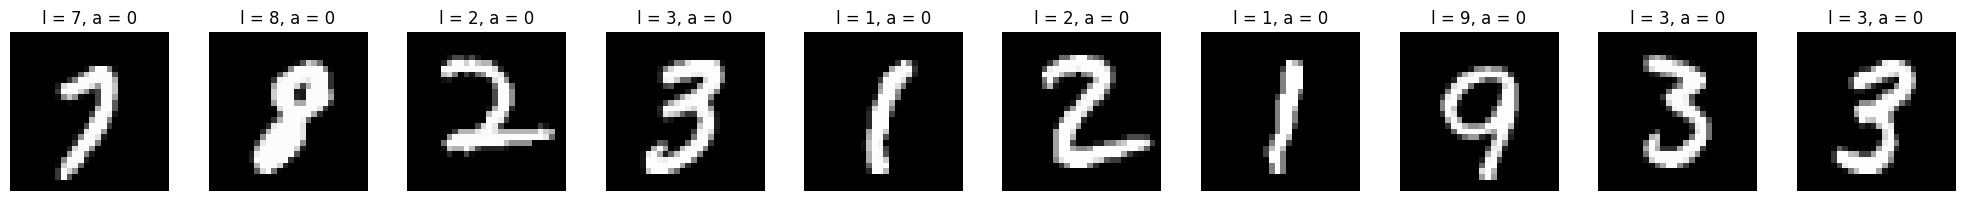

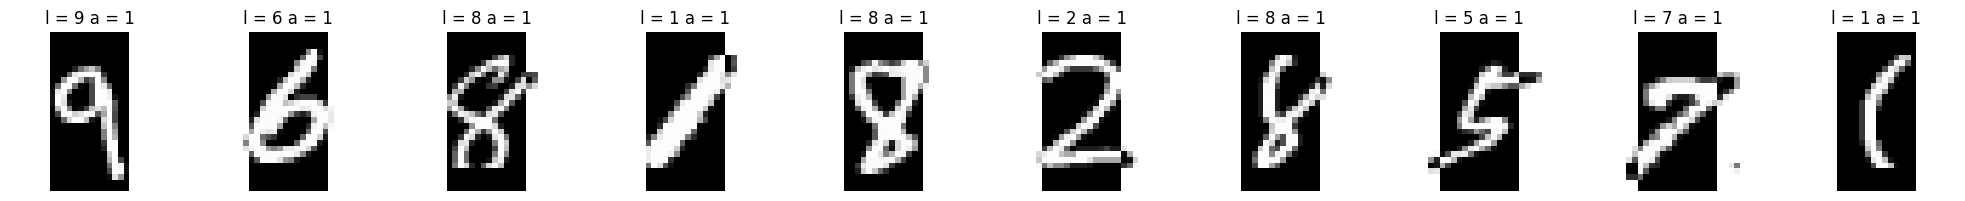

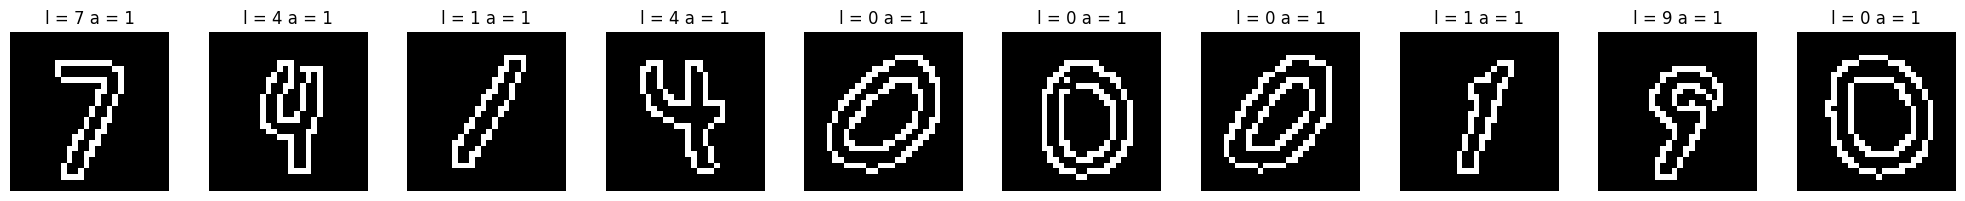

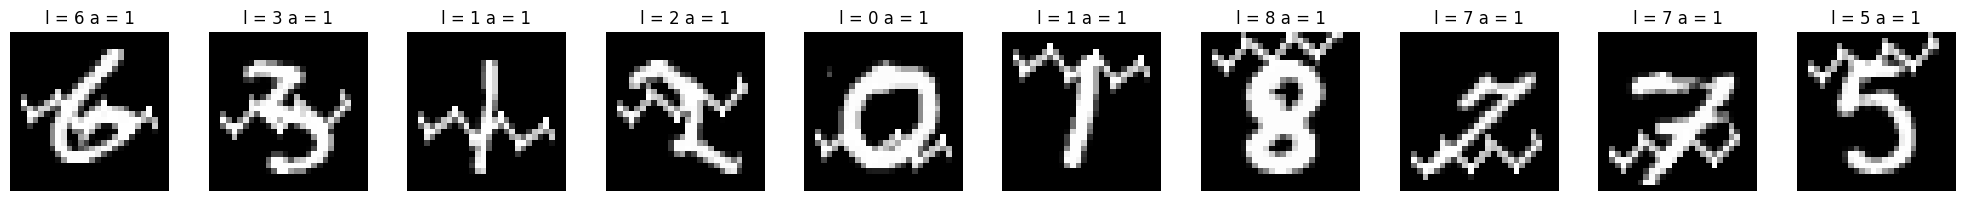

In [79]:
#test the data by loading it, and plotting 10 images between 0 and 59999, and 10 images between 60000 and 60599, and 10 images between 60600 and 61199, and 10 images between 61200 and 61799
#the images will plotted as a 28x28 image and the plot will be labeled with the class of image and the anomaly label
#load the data
X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
y = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', allow_pickle=True)
y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')

#original data plots, in subplot that is 1 row and 10 columns
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(f'l = {y[i]}, a = {y_anomaly[i]}')
    ax[i].axis('off')   
plt.tight_layout()    
plt.show()

for corrupt_index in range(N_corruptions):
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        ax[i].imshow(X[N1 + corrupt_index*N_corrupt + i], cmap='gray')
        ax[i].set_title(f'l = {y[N1 + corrupt_index*N_corrupt + i]} a = {y_anomaly[N1 + corrupt_index*N_corrupt + i]}')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()




In [80]:

#generate a probability density based anomaly detection model
#load the data
#split into training and testing
X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
X_784 = X.reshape(-1, 28*28)
y = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', allow_pickle=True)
y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')

X_train, X_test, y_train, y_test = train_test_split(X_784, y_anomaly, train_size=0.8, test_size=0.2)

#print statistics of training and testing data
print(f'Training data has {X_train.shape[0]} samples')
print(f'Testing data has {X_test.shape[0]} samples')
print(f'Training data has {y_train[y_train == 0].shape[0]} normal samples' + f' and {y_train[y_train == 1].shape[0]} anomaly samples')
print(f'Testing data has {y_test[y_test == 0].shape[0]} normal samples' + f' and {y_test[y_test == 1].shape[0]} anomaly samples')

for knnc_test in knnc_test_scenarios:
    knnc = KNeighborsClassifier(n_neighbors=knnc_test)
    knnc.fit(X_train, y_train)
    #y_test_pred = knnc.predict(X_test)
    knnc_proba.append( knnc.predict_proba(X_test)[:,1])
    #knnc_proba.append(roc_auc_score(y_test, y_test_prob))
    
#knnc = KNeighborsClassifier(n_neighbors=100)
#knnc.fit(X_train, y_train)
#y_test_pred = knnc.predict(X_test)
#y_test_prob = knnc.predict_proba(X_test)[:,1]   #used to generate the ROC curve and the precision recall curve

#plt.plot(y_test_prob)
#plt.show()


#roc_auc_score(y_test, y_test_prob)

#plot the ROC curve using sklearn

for test_index, knnc_test in enumerate(knnc_test_scenarios):
    fpr, tpr, thresholds = roc_curve(y_test, knnc_proba[test_index])    
    plt.plot(fpr, tpr, label=f'k = {knnc_test}')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
    #add a random classifier line to the plot, slope = 1, intercept = 0
plt.plot([0,1],[0,1], linestyle='--', label='Random classifier')
plt.show()
    

#generate precision and recall curve
for test_index, knnc_test in enumerate(knnc_test_scenarios):
    precision, recall, thresholds = precision_recall_curve(y_test, knnc_proba[test_index])    
    plt.plot(recall, precision, label=f'k = {knnc_test}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.show()

Training data has 49440 samples
Testing data has 12360 samples
Training data has 47967 normal samples and 1473 anomaly samples
Testing data has 12033 normal samples and 327 anomaly samples


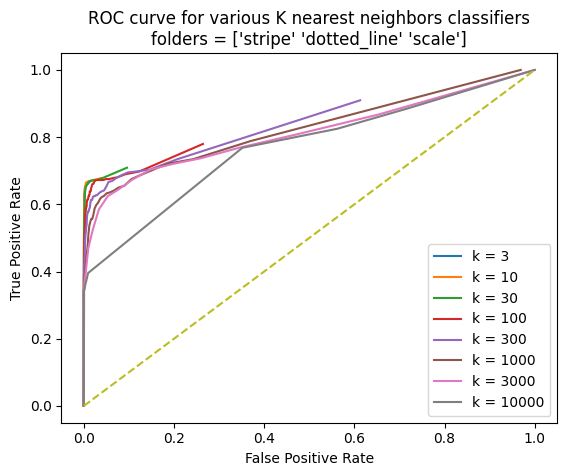

In [ ]:
#generate roc curve from scratch
#generate the thresholds
tpr = np.zeros((len(knnc_test_scenarios), 100))
fpr = np.zeros((len(knnc_test_scenarios), 100))
thresholds = np.linspace(0,1,100)    
for test_index, knnc_test in enumerate(knnc_test_scenarios):    
    for i, threshold in enumerate(thresholds):
        y_test_pred = knnc_proba[test_index] > threshold
        if np.sum(y_test==1) == 0:
            tpr[test_index][i] = 1
            fpr[test_index][i] = np.sum((y_test == 0) & (y_test_pred == 1)) / np.sum(y_test == 0)
        elif np.sum(y_test==0) == 0:
            fpr[test_index][i] = 1
            tpr[test_index][i] = np.sum((y_test == 1) & (y_test_pred == 1)) / np.sum(y_test == 1)
        else:            
            tpr[test_index][i] = np.sum((y_test == 1) & (y_test_pred == 1)) / np.sum(y_test == 1)
            fpr[test_index][i] = np.sum((y_test == 0) & (y_test_pred == 1)) / np.sum(y_test == 0)
        
    
    plt.plot(fpr[test_index], tpr[test_index], label=f'k = {knnc_test_scenarios[test_index]}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')
#add a random classifier line to the plot, slope = 1, intercept = 0
plt.plot([0,1],[0,1], linestyle='--')
plt.legend()
plt.savefig('roc_curve_' + '_'.join(choose_N_folders) + '.png')
plt.show()


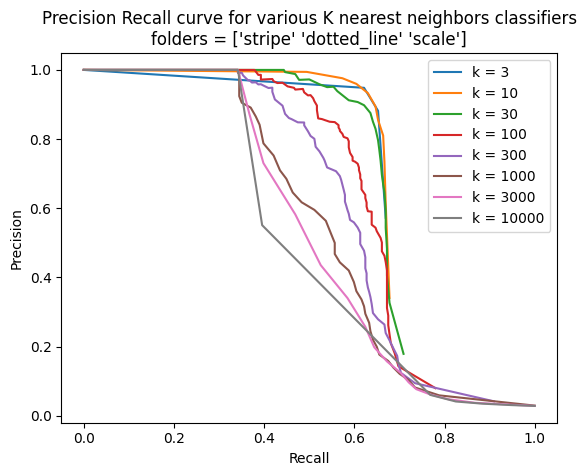

In [ ]:
#generate precision and recall curve from scratch
precision = np.zeros((len(knnc_test_scenarios), 100))
recall = np.zeros((len(knnc_test_scenarios), 100))
thresholds = np.linspace(0,1,100)    
for test_index, knnc_test in enumerate(knnc_test_scenarios):
    for i, threshold in enumerate(thresholds):
        y_test_pred =  knnc_proba[test_index] > threshold
        if np.sum(y_test_pred == 1) == 0:
            precision[test_index][i] = 1
            recall[test_index][i] = 0
        elif np.sum(y_test == 1) == 0:
            precision[test_index][i] = 0
            recall[test_index][i] = 1
        else:
            precision[test_index][i] = np.sum((y_test == 1) & (y_test_pred == 1)) / np.sum(y_test_pred == 1)
            recall[test_index][i] = np.sum((y_test == 1) & (y_test_pred == 1)) / np.sum(y_test == 1)
        
    plt.plot(recall[test_index], precision[test_index], label=f'k = {knnc_test_scenarios[test_index]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision Recall curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')
plt.legend()
plt.savefig('Precision_recall_' + '_'.join(choose_N_folders) + '.png')
plt.show()


In [ ]:
#lib imports
import numpy as np
import matplotlib.pyplot as plt
from adbench.baseline.Supervised import supervised
from sklearn.model_selection import train_test_split
#import confusion_matrix_pretty_print

#function definitions
def test_supervised(X_train, X_test, y_train, y_test, model_name='XGB', verbose=False):
    """
    Test a supervised model on the given training and testing data.

    Parameters:
    - X_train (array-like): Training data features.
    - X_test (array-like): Testing data features.
    - y_train (array-like): Training data labels.
    - y_test (array-like): Testing data labels.
    - model_name (str): Name of the model to use (default: 'XGB').
    - verbose (bool): Whether to print verbose output (default: False).

    Returns:
    - model: Trained supervised model.
    - score: Prediction score on the testing data.
    """
    model = supervised(seed=42, model_name=model_name)  # initialization
    model.fit(X_train, y_train) # training
    score = model.predict_score(X_test)
              
    return model, score

def print_statistics(score, y):
    """
    Prints statistics for the scores based on the labels.

    Parameters:
    score (numpy.ndarray): Array of scores.
    y (numpy.ndarray): Array of labels.

    Returns:
    None
    """
    #find unique values of y
    print("Printing statistics for the scores")
    y_labels, y_counts = np.unique(y, return_counts=True)    
    print(f'{y_labels=} {y_counts=}')    
    
    for i, label in enumerate(y_labels):
        print('Class {} has {} samples'.format(label, y_counts[i]))
        print(f'mean = {score[y==label].mean()}, std = {score[y==label].std()}, min = {score[y==label].min()}, max = {score[y==label].max()}')

def plot_histograms(score, y):
    """
    Plots histograms of scores based on different classes.

    Parameters:
    score (numpy.ndarray): Array of scores.
    y (numpy.ndarray): Array of class labels.

    Returns:
    matplotlib.figure.Figure: The figure object.
    matplotlib.axes.Axes: The axes object.
    """
    #find unique values of y
    y_labels, y_counts = np.unique(y, return_counts=True)
    fig, ax = plt.subplots()
    for i, label in enumerate(y_labels):
        ax.hist(score[y==label], bins=np.linspace(0,1,100), alpha=0.5, label='Class {}'.format(label), log=True)          

    ax.set_xlabel('Score')
    ax.set_ylabel('Log Count')    
    return fig, ax
    
def get_threshold(score, y, sigmaP=3):
    """
    Calculate the threshold value based on the given score and labels.

    Parameters:
    score (array-like): The scores for each sample.
    y (array-like): The labels for each sample.
    sigmaP (float, optional): The number of standard deviations to add to the mean of the scores for class 0. Default is 3.

    Returns:
    float: The calculated threshold value.
    """
    return score[y==0].mean() + sigmaP*score[y==0].std()
    
def evaluate_at_threshold(threshold, score, y):
    """
    Evaluate the performance of a binary classification model at a given threshold. Brute force method.

    Parameters:
    threshold (float): The threshold value for classification.
    score (array-like): The predicted scores for each sample.
    y (array-like): The true labels for each sample.

    Returns:
    None
    """
    print(f'Threshold = {threshold}')
    y_pred = score > threshold
    y_correct = y_pred == y
    accuracy =y_correct.sum() / len(y_correct)
    anomaly_actual = y.sum()
    anomaly_predicted = y_pred.sum()
    anomaly_actual_correct  = (y_pred.astype(bool) & y.astype(bool)).sum()
    anomaly_actual_incorrect  = (y_pred.astype(bool) & ~y.astype(bool)).sum()
    non_anomaly_actual_correct  = (~y_pred.astype(bool) & ~y.astype(bool)).sum()
    non_anomaly_actual_incorrect  = (~y_pred.astype(bool) & y.astype(bool)).sum()
    non_anomaly_actual = len(y) - y.sum()
    non_anomaly_predicted = len(y) - y_pred.sum()


    print(f'Accuracy = {accuracy}')
    print(f'Number of anomalies = {anomaly_actual}')
    print(f'Number of anomalies detected = {anomaly_predicted}')
    print(f'Number of anomalies detected correctly = {anomaly_actual_correct}')
    print(f'Number of anomalies detected incorrectly = {anomaly_actual_incorrect}')
    print(f'Number of non-anomalies detected correctly = {non_anomaly_actual_correct}')
    print(f'Number of non-anomalies detected incorrectly = {non_anomaly_actual_incorrect}')
    print(f'Number of non-anomalies = {non_anomaly_actual}')
    print(f'Number of non-anomalies detected = {non_anomaly_predicted}')
    print(f'Precision = {anomaly_actual_correct / anomaly_predicted}')
    print(f'Recall = {anomaly_actual_correct / anomaly_actual}')